🔍 Exploring rule combinations...

Temp: 75°C, Window: 24h, Threshold: 15% → Detected: 40 windows
Temp: 75°C, Window: 24h, Threshold: 20% → Detected: 39 windows
Temp: 75°C, Window: 24h, Threshold: 25% → Detected: 35 windows
Temp: 75°C, Window: 24h, Threshold: 30% → Detected: 36 windows
Temp: 75°C, Window: 48h, Threshold: 15% → Detected: 23 windows
Temp: 75°C, Window: 48h, Threshold: 20% → Detected: 20 windows
Temp: 75°C, Window: 48h, Threshold: 25% → Detected: 19 windows
Temp: 75°C, Window: 48h, Threshold: 30% → Detected: 20 windows
Temp: 75°C, Window: 72h, Threshold: 15% → Detected: 20 windows
Temp: 75°C, Window: 72h, Threshold: 20% → Detected: 18 windows
Temp: 75°C, Window: 72h, Threshold: 25% → Detected: 17 windows
Temp: 75°C, Window: 72h, Threshold: 30% → Detected: 17 windows
Temp: 76°C, Window: 24h, Threshold: 15% → Detected: 35 windows
Temp: 76°C, Window: 24h, Threshold: 20% → Detected: 33 windows
Temp: 76°C, Window: 24h, Threshold: 25% → Detected: 34 windows
Temp: 76°C, Window: 2

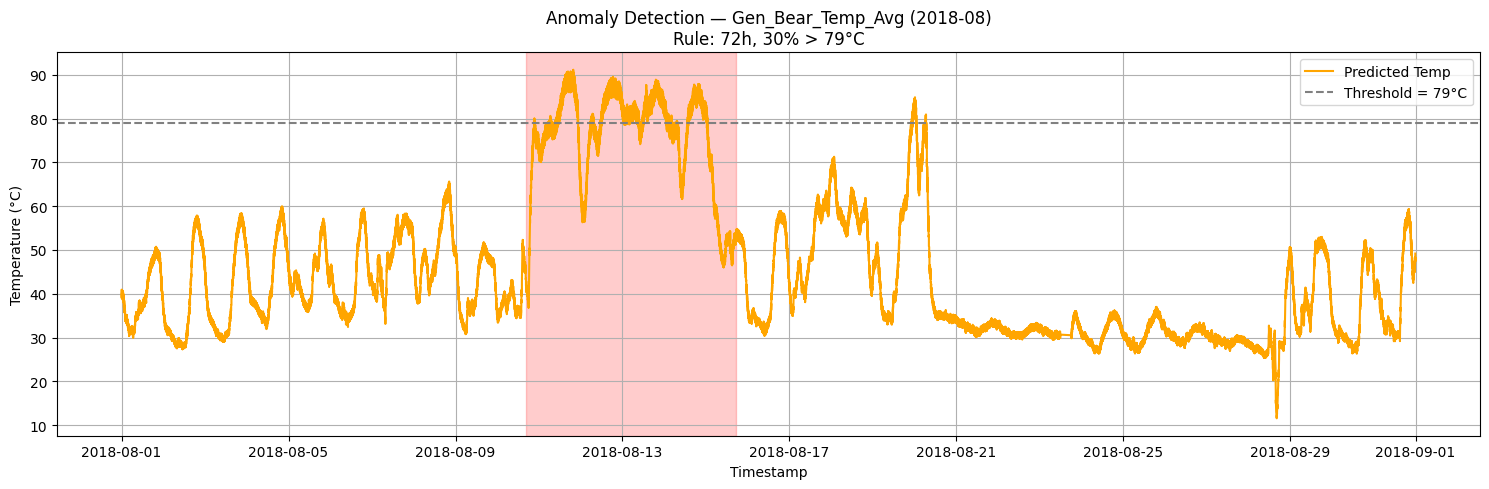

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load Predicted Data ===
pred_df = pd.read_csv("C:/Own use/Thesis/Wind_Turbine/Datasets/Scada_Data(Wind_Turbine)/Wind-Turbine-SCADA-signals-2016/Without_Grd_Column/Latest/DigitalTwin/Predicted_Future_SCADA_Data_from_2016_&_2017_Autoencoder.csv")
pred_df['Timestamp'] = pd.to_datetime(pred_df['Timestamp'])
pred_df = pred_df.sort_values('Timestamp').reset_index(drop=True)

# === Rule-Based Anomaly Detection Function ===
def evaluate_rule(df, feature='Gen_Bear_Temp_Avg', threshold_temp=80,
                  percent_required=0.25, window_hours=72, freq_minutes=10):
    
    df = df.copy()
    window_size = int((window_hours * 60) / freq_minutes)
    df['HighTempFlag'] = df[feature] > threshold_temp
    df['Anomaly'] = 0

    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i+window_size]
        if window['HighTempFlag'].mean() > percent_required:
            df.loc[df.index[i]:df.index[i+window_size-1], 'Anomaly'] = 1

    return df

# === Grid Search to Find Most Informative Rule ===
best_score = -1
best_combo = None

print(" Exploring rule combinations...\n")
for temp_thresh in range(75, 86):  # 75°C to 85°C
    for window_hours in [24, 48, 72]:
        for percent in [0.15, 0.2, 0.25, 0.3]:
            df_eval = evaluate_rule(pred_df,
                                    threshold_temp=temp_thresh,
                                    window_hours=window_hours,
                                    percent_required=percent)
            
            # Count how many unique anomaly windows
            df_eval['Group'] = (df_eval['Anomaly'] != df_eval['Anomaly'].shift()).cumsum()
            anomaly_groups = df_eval[df_eval['Anomaly'] == 1].groupby('Group')['Timestamp'].agg(['min', 'max'])
            num_anomalies = len(anomaly_groups)

            # Score: avoid too few (<1) or too many (>50) anomalies
            score = -abs(10 - num_anomalies)  # Ideal is ~10 anomaly windows

            print(f"Temp: {temp_thresh}°C, Window: {window_hours}h, Threshold: {int(percent*100)}% → Detected: {num_anomalies} windows")

            if score > best_score:
                best_score = score
                best_combo = (temp_thresh, window_hours, percent)

# === Best Rule Found ===
best_threshold, best_window, best_percent = best_combo
print("\n Best Rule Based on Natural Pattern:")
print(f"Temperature Threshold: {best_threshold}°C")
print(f"Duration: {best_window} hours")
print(f"Percentage Threshold: {int(best_percent * 100)}%")

# === Apply Best Rule ===
final_df = evaluate_rule(pred_df,
                         threshold_temp=best_threshold,
                         window_hours=best_window,
                         percent_required=best_percent)

# === Plot for August (or any month) ===
target_year = 2018
target_month = 8

month_df = final_df[(final_df['Timestamp'].dt.year == target_year) &
                    (final_df['Timestamp'].dt.month == target_month)].copy()

month_df['Group'] = (month_df['Anomaly'] != month_df['Anomaly'].shift()).cumsum()
month_anomalies = month_df[month_df['Anomaly'] == 1].groupby('Group')['Timestamp'].agg(['min', 'max'])

# === Plot ===
plt.figure(figsize=(15, 5))
plt.plot(month_df['Timestamp'], month_df['Gen_Bear_Temp_Avg'], label='Predicted Temp', color='orange')
plt.axhline(best_threshold, color='gray', linestyle='--', label=f'Threshold = {best_threshold}°C')

for _, row in month_anomalies.iterrows():
    plt.axvspan(row['min'], row['max'], color='red', alpha=0.2)

plt.title(f"Anomaly Detection — Gen_Bear_Temp_Avg ({target_year}-{target_month:02d})\nRule: {best_window}h, {int(best_percent*100)}% > {best_threshold}°C")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


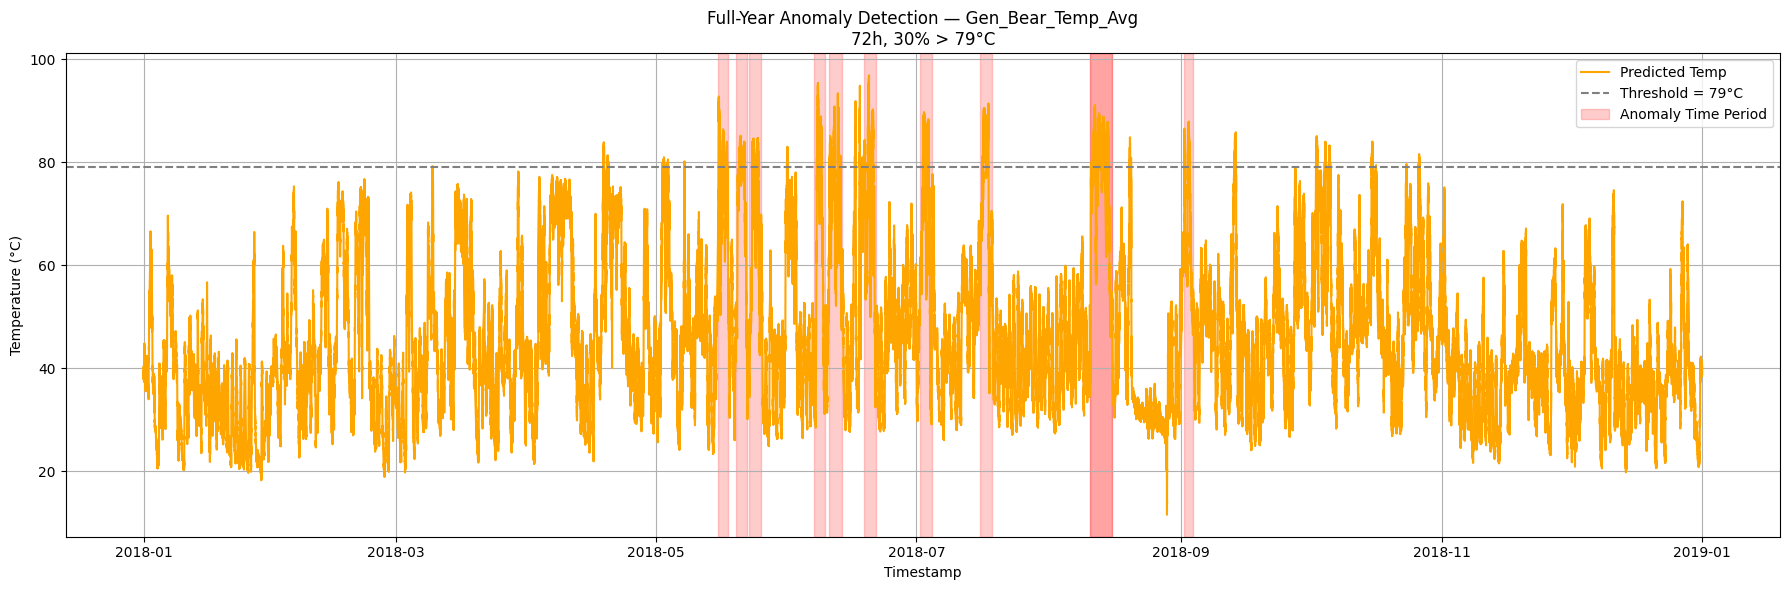

In [7]:
# === Group anomalies over the whole dataset ===
final_df['Group'] = (final_df['Anomaly'] != final_df['Anomaly'].shift()).cumsum()
full_year_anomalies = final_df[final_df['Anomaly'] == 1].groupby('Group')['Timestamp'].agg(['min', 'max'])

# === Plot for Whole Year ===
plt.figure(figsize=(18, 6))
plt.plot(final_df['Timestamp'], final_df['Gen_Bear_Temp_Avg'], label='Predicted Temp', color='orange')
plt.axhline(best_threshold, color='gray', linestyle='--', label=f'Threshold = {best_threshold}°C')

# Add anomaly span with label only once
labeled = False
for _, row in month_anomalies.iterrows():
    if not labeled:
        plt.axvspan(row['min'], row['max'], color='red', alpha=0.2, label='Anomaly Time Period')
        labeled = True
    else:
        plt.axvspan(row['min'], row['max'], color='red', alpha=0.2)
# Shade anomaly areas
for _, row in full_year_anomalies.iterrows():
    plt.axvspan(row['min'], row['max'], color='red', alpha=0.2)

# Labels
plt.title(f"Full-Year Anomaly Detection — Gen_Bear_Temp_Avg\n{best_window}h, {int(best_percent*100)}% > {best_threshold}°C")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
full_anomaly_windows = full_pred_df[full_pred_df['Anomaly'] == 1].groupby('Group')['Timestamp'].agg(['min', 'max'])


In [9]:
# === Calculate Duration in Hours ===
full_anomaly_windows['Duration'] = (full_anomaly_windows['max'] - full_anomaly_windows['min']).dt.total_seconds() / 3600  # in hours

# === Save or Show the Anomaly List ===
full_anomaly_windows = full_anomaly_windows.rename(columns={'min': 'Start_Time', 'max': 'End_Time'})
full_anomaly_windows.to_csv("Anomaly_Timestamps_With_Duration.csv", index=False)

print("✅ Anomaly list with duration saved as: Anomaly_Timestamps_With_Duration.csv")
print(full_anomaly_windows.head())


✅ Anomaly list with duration saved as: Anomaly_Timestamps_With_Duration.csv
Empty DataFrame
Columns: [Start_Time, End_Time, Duration]
Index: []


In [12]:
# === Group anomalies for full year ===
final_df['Group'] = (final_df['Anomaly'] != final_df['Anomaly'].shift()).cumsum()
full_anomaly_windows = final_df[final_df['Anomaly'] == 1].groupby('Group')['Timestamp'].agg(['min', 'max'])

# === Calculate Duration in Hours ===
full_anomaly_windows['Duration_hours'] = (full_anomaly_windows['max'] - full_anomaly_windows['min']).dt.total_seconds() / 3600

# === Rename Columns ===
full_anomaly_windows = full_anomaly_windows.rename(columns={'min': 'Start_Time', 'max': 'End_Time'})

# === Save to CSV ===
full_anomaly_windows.to_csv("C:/Own use/Thesis/Wind_Turbine/Datasets/Scada_Data(Wind_Turbine)/Wind-Turbine-SCADA-signals-2016/Without_Grd_Column/Latest/DigitalTwin/2018_Anomaly_Timestamps_With_Duration.csv", index=False)

# === Preview ===
print("✅ Anomaly list with duration saved as: Anomaly_Timestamps_With_Duration.csv")
print(full_anomaly_windows.head())


✅ Anomaly list with duration saved as: Anomaly_Timestamps_With_Duration.csv
                     Start_Time                  End_Time  Duration_hours
Group                                                                    
2     2017-04-30 15:20:00+00:00 2017-05-05 22:20:00+00:00      127.000000
4     2017-06-19 10:50:00+00:00 2017-06-24 17:50:00+00:00      127.000000
6     2017-07-12 06:50:00+00:00 2017-07-20 21:40:00+00:00      206.833333
8     2017-07-22 07:20:00+00:00 2017-07-28 09:50:00+00:00      146.500000
10    2017-08-04 06:10:00+00:00 2017-08-15 17:10:00+00:00      275.000000
